<a href="https://colab.research.google.com/github/tarushi1/TraffiGuard/blob/main/DQNModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install torch gym numpy matplotlib stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 876.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [3]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

In [18]:
# Traffic Signal Environment
class TrafficEnv(gym.Env):
    def __init__(self):
        super(TrafficEnv, self).__init__()
        self.action_space = gym.spaces.Discrete(3)  # Actions: Extend, Reduce, Switch
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(3,), dtype=np.float32)
        self.state = np.array([50, 0, 0], dtype=np.float32)  # [traffic_density, emergency_vehicle, signal_state]
        self.done = False

    def step(self, action):
        traffic_density, emergency_vehicle, signal_state = self.state

        if action == 0:  # Extend green light
            traffic_density -= 5
        elif action == 1:  # Reduce green light
            traffic_density += 5
        elif action == 2:  # Switch signal
            signal_state = 1 - signal_state
        # Reward system
        reward = -traffic_density if emergency_vehicle == 1 else 10 - traffic_density
        if emergency_vehicle == 1 and traffic_density < 10:
            reward += 50  # High reward for prioritizing emergency
            self.done = True

        self.state = np.array([traffic_density, emergency_vehicle, signal_state], dtype=np.float32)
        return self.state, reward, self.done, {}

    def reset(self):
        self.state = np.array([50, random.choice([0, 1]), 0], dtype=np.float32)
        self.done = False
        return self.state


In [19]:
# Define the DQN Network
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

In [23]:
# DQN Agent with Optimized Parameters
class DQNAgent:
    def __init__(self, state_dim, action_dim):
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.0005)  # 🔥 Lower learning rate
        self.criterion = nn.MSELoss()
        self.memory = deque(maxlen=10000)  # 🔥 Increased replay memory size
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.998
        self.epsilon_min = 0.05  # 🔥 Increased min epsilon to keep some exploration
        self.update_target_every = 5  # 🔥 More frequent target network updates

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return random.choice([0, 1, 2])
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self, batch_size=32):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in batch:
            state_tensor = torch.FloatTensor(state)
            next_state_tensor = torch.FloatTensor(next_state)
            q_update = reward
            if not done:
                q_update += self.gamma * torch.max(self.target_model(next_state_tensor)).item()

            q_values = self.model(state_tensor)
            target_q_values = q_values.clone()
            target_q_values[action] = q_update

            loss = self.criterion(q_values, target_q_values.detach())
            self.optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)  # 🔥 Gradient Clipping
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

In [24]:
# Training the DQN Model with Improvements
env = TrafficEnv()
agent = DQNAgent(state_dim=3, action_dim=3)
episodes = 1000  # 🔥 More training episodes
reward_history = []

for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    for _ in range(100):
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break

    agent.replay()
    reward_history.append(total_reward)

    if episode % agent.update_target_every == 0:  # 🔥 More frequent target updates
        agent.update_target_model()

    print(f"Episode {episode+1}/{episodes}, Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")


Episode 1/1000, Reward: -5115.0, Epsilon: 1.00
Episode 2/1000, Reward: -2630.0, Epsilon: 1.00
Episode 3/1000, Reward: -6605.0, Epsilon: 0.99
Episode 4/1000, Reward: -2490.0, Epsilon: 0.99
Episode 5/1000, Reward: -6640.0, Epsilon: 0.99
Episode 6/1000, Reward: -50.0, Epsilon: 0.99
Episode 7/1000, Reward: -5760.0, Epsilon: 0.99
Episode 8/1000, Reward: -7715.0, Epsilon: 0.98
Episode 9/1000, Reward: -3400.0, Epsilon: 0.98
Episode 10/1000, Reward: -5380.0, Epsilon: 0.98
Episode 11/1000, Reward: -3530.0, Epsilon: 0.98
Episode 12/1000, Reward: -3740.0, Epsilon: 0.98
Episode 13/1000, Reward: -890.0, Epsilon: 0.97
Episode 14/1000, Reward: -3545.0, Epsilon: 0.97
Episode 15/1000, Reward: -8155.0, Epsilon: 0.97
Episode 16/1000, Reward: -3260.0, Epsilon: 0.97
Episode 17/1000, Reward: -6420.0, Epsilon: 0.97
Episode 18/1000, Reward: -4385.0, Epsilon: 0.96
Episode 19/1000, Reward: -1655.0, Epsilon: 0.96
Episode 20/1000, Reward: -2575.0, Epsilon: 0.96
Episode 21/1000, Reward: -225.0, Epsilon: 0.96
Episo

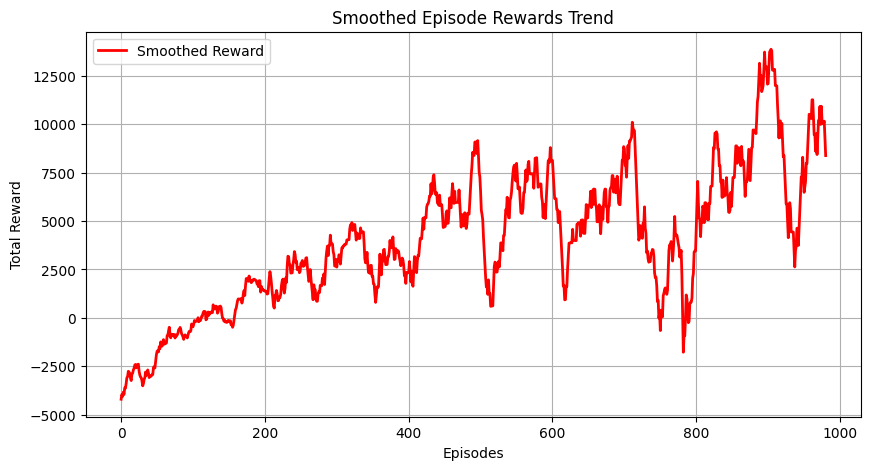

In [25]:
window = 20  # Moving average window size
smoothed_rewards = np.convolve(reward_history, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10, 5))
plt.plot(smoothed_rewards, label="Smoothed Reward", color="red", linewidth=2)
plt.xlabel("Episodes")
plt.ylabel("Total Reward")
plt.title("Smoothed Episode Rewards Trend")
plt.legend()
plt.grid()
plt.show()
